# **1. Import Libraries**

In [3]:
import os
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Categorising the class to fruits and vegetables

In [5]:
import json

# Path to the JSON file
json_file_path = '../artifacts/dataset/fruits-and-vegetables.json'

# Define the classes to be added
categories = {
    "fruits": ["apple", "mango"],
    "vegetables": ["potato", "tomato"]
}

# Load existing data from the JSON file
try:
    with open(json_file_path, 'r') as file:
        data = json.load(file)
except FileNotFoundError:
    # If file does not exist, initialize it with empty dictionaries
    data = {}

# Ensure that the file starts with lists
for category, classes in categories.items():
    if category not in data:
        data[category] = []
    for class_name in classes:
        if class_name not in data[category]:
            data[category].append(class_name)

# Write the updated data back to the JSON file
with open(json_file_path, 'w') as file:
    json.dump(data, file, indent=4)

print("JSON file updated successfully.")


JSON file updated successfully.


# **2. Import Data**

In [6]:
train_dir = '../artifacts/dataset/train'
validation_dir = '../artifacts/dataset/validation'

print(train_dir, validation_dir)

../artifacts/dataset/train ../artifacts/dataset/validation


# **2.1 Count data and classes**

In [7]:
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(folder_dir)]
    
    print(colored(f'number of classes in {folder_name} folder: {len(classes)}', 'blue', attrs=['bold']))

In [8]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')

number of classes in train folder: 4
number of classes in validation folder: 4


In [9]:
# work on train folder and count the number of samples in  per each class

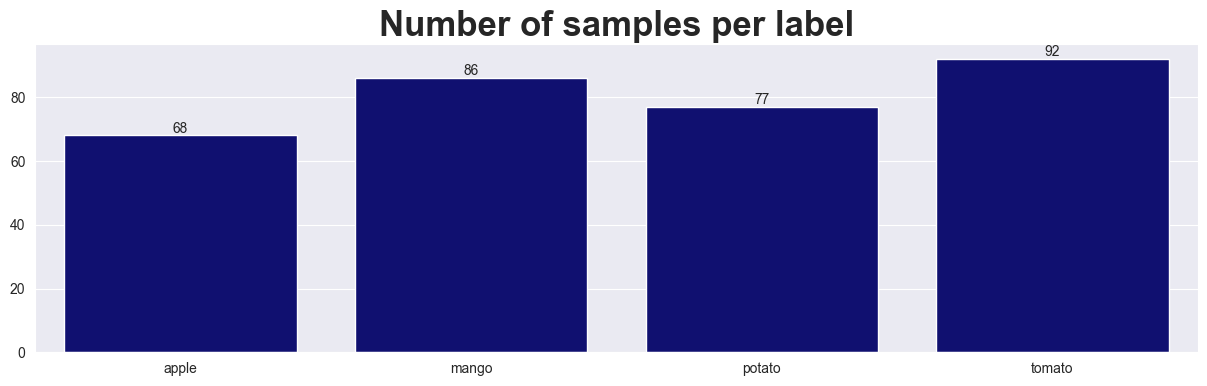

<Figure size 1500x400 with 0 Axes>

In [10]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes:
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))
    
plt.figure(figsize=(15,4))
ax = sns.barplot(x=classes, y=count, color='navy')
# plt.xticks(rotation=90)

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.figure(figsize=(15,4))
plt.show()

# **2.2 Convert data to a DataFrame**

In [11]:
# A function to return DataFrame

def create_df(folder_path_1):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path_1, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
        
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df


In [12]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)

print(colored(f'number of samples in train: {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'number of samples in validation: {len(validation_df)}', 'blue', attrs=['bold']))

number of samples in train: 323
number of samples in validation: 40


# **2.3 Show an image per each class(label)**

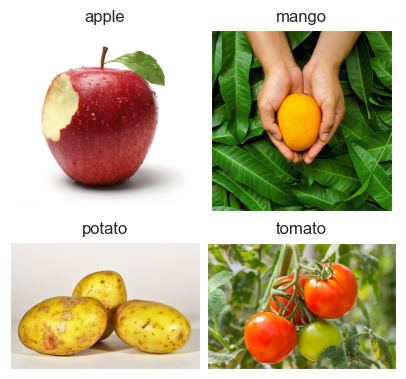

In [13]:
# Fruits

# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# **2.4 Data generators**

In [14]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,      # Scaled images in range 0 to 1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,      # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,                  
    shuffle=True,
    seed=42,
)


# Validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 323 validated image filenames belonging to 4 classes.
Found 40 validated image filenames belonging to 4 classes.


In [15]:
class_dict = train_generator.class_indices
subject = "fruits_and_vegetables"
save_path = "../artifacts/dataset"
Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
class_df = pd.concat([Index_series, Class_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as ../artifacts/dataset\fruits_and_vegetables-class_dict.csv


# **3. Add MobileNetv2 model**

In [13]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),  # Input image size
    include_top=False,          # Exclude top layer
    weights='imagenet',         # Use pre-trained weights
    pooling='avg'               # Global average pooling
)

# **3.1 Freeze MobileNetV2 layers**

In [14]:
# for layer in pre_trained_model.layers:
#     layer.trainable = False

In [15]:
# # Freeze all layers, except last layer
# # The goal is to train just last layer of pre trained model

# pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

# **3.2 Define a model**

In [16]:
# Add custom layers on top of the base model
# model = models.Sequential()
# model.add(pre_trained_model)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(4, activation='softmax'))

# Add custom layers on top
# x = pre_trained_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
# predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# # Define the model
# model = Model(inputs=pre_trained_model.input, outputs=predictions)

model = models.Sequential([
    pre_trained_model,  # Base EfficientNet model
    Dense(256, activation='relu'),  # Example dense layer
    Dense(128, activation='relu'),  # Example dense layer
    Dropout(0.5),                   # Example dropout layer
    Dense(4, activation='softmax')  # Output layer for classification
])

# **3.3 Model Diagram**

In [17]:
# Build the model by specifying the input shape
model.build((None, 224, 224, 3))

# Now plot the model
# plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 1,247,428 (4.76 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

# **3.4 Compile Model**

In [19]:
# model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
#              loss=CategoricalCrossentropy(), 
#              metrics=['accuracy'])

# # print("Model output shape:", model.output_shape)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Model output shape:", model.output_shape)

Model output shape: (None, 4)


# **3.5 CallBacks**

In [20]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('../artifacts/models/MyModel.keras', monitor='val_accuracy', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Inspecting a batch from the train generator
x_batch, y_batch = next(train_generator)
print(x_batch.shape, y_batch.shape)


(32, 224, 224, 3) (32, 4)


In [21]:
print(train_df.head())
print(validation_df.head())

                                       file_path  label
0   ../artifacts/dataset/train\apple\Image_1.jpg  apple
1  ../artifacts/dataset/train\apple\Image_10.jpg  apple
2  ../artifacts/dataset/train\apple\Image_16.jpg  apple
3  ../artifacts/dataset/train\apple\Image_17.jpg  apple
4  ../artifacts/dataset/train\apple\Image_18.jpg  apple
                                           file_path  label
0  ../artifacts/dataset/validation\apple\Image_1.jpg  apple
1  ../artifacts/dataset/validation\apple\Image_10...  apple
2  ../artifacts/dataset/validation\apple\Image_2.jpg  apple
3  ../artifacts/dataset/validation\apple\Image_3.jpg  apple
4  ../artifacts/dataset/validation\apple\Image_4.jpg  apple


# **Train Model**

In [22]:
print("Starting training...")

try:
    history = model.fit(
        train_generator,
        batch_size=16,
        steps_per_epoch=30,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=15,   
        callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
    )
    
except Exception as e:
    print(f"Error during training: {e}")
        
print("Training completed.")

Starting training...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.3516 - loss: 1.4164 - val_accuracy: 0.6500 - val_loss: 0.9743 - learning_rate: 1.0000e-04
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - accuracy: 0.6242 - loss: 0.9500 - val_accuracy: 0.8000 - val_loss: 0.6801 - learning_rate: 1.0000e-04
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 217ms/step - accuracy: 0.7591 - loss: 0.7224 - val_accuracy: 0.8250 - val_loss: 0.4826 - learning_rate: 1.0000e-04
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.8312 - loss: 0.5157 - val_accuracy: 0.8250 - val_loss: 0.3997 - learning_rate: 1.0000e-04
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.8767 - loss: 0.4370 - val_accuracy: 0.8250 - val_loss: 0.4200 - learning_rate: 1.0000e-04
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 231ms/step - accuracy: 0.8705 - loss: 0.4000 - val_accuracy: 0.9250 - val_loss: 0.2816 - learning_rate: 1.0000e-04
Epoch 7/100
30/30 ━━━━━━━━━━━━━

In [23]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
21,0.978328,0.074774,0.925,0.154590,0.000050
22,0.978328,0.075708,0.925,0.163423,0.000050
23,0.965944,0.083769,0.925,0.159471,0.000050
24,0.969040,0.092013,0.925,0.155919,0.000025
25,0.978328,0.061799,0.925,0.145173,0.000025


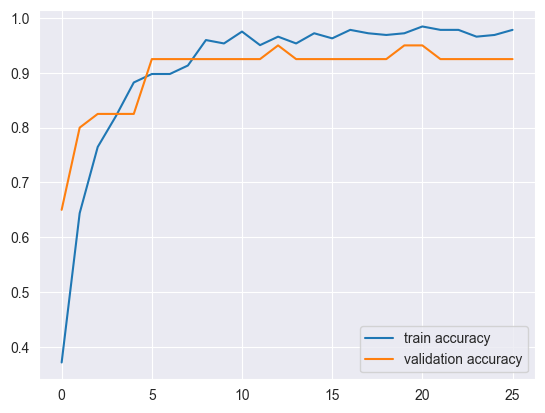

In [24]:
# plot the accuracy value 
plt.plot(history.history['accuracy'],label='train accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

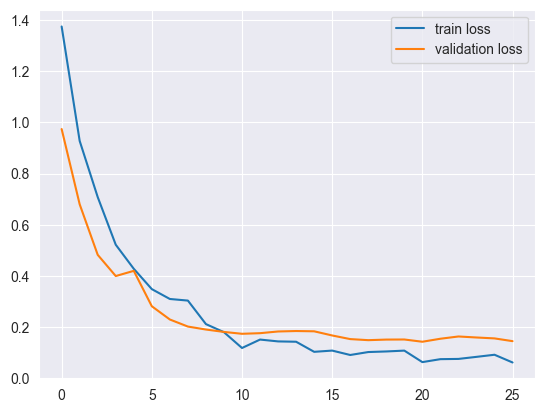

In [25]:
# plot the loss value 
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

In [26]:
# Save the trained model
keras.saving.save_model(model, '../artifacts/models/trained_model.h5')
keras.saving.save_model(model, '../artifacts/models/trained_model.keras')